# Simplified Centralized Federated Learning Analysis

This notebook analyzes the simplified metrics from centralized federated learning experiments:
- Global model metrics (accuracy, loss, gradient norm, gradient change)
- Per-client metrics (accuracy, loss, gradient norm, gradient change)
- Per-class metrics for both global and clients

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Load Data

Load the simplified centralized metrics from the latest experiment.

In [2]:
# Find the latest centralized experiment
logs_dir = Path('logs/centralized_fedavg')

# Get all experiment directories sorted by modification time (latest first)
experiment_dirs = sorted(
    [p for p in logs_dir.glob('*') if p.is_dir()],
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

if not experiment_dirs:
    raise ValueError("No centralized experiments found in logs/centralized")

# Use the latest experiment
experiment_dir = experiment_dirs[0]
print(f"Loading data from: {experiment_dir}")

# Load the four simplified CSV files
global_metrics = pd.read_csv(experiment_dir / 'centralized_global_metrics.csv')
global_per_class = pd.read_csv(experiment_dir / 'centralized_global_per_class_metrics.csv')
client_metrics = pd.read_csv(experiment_dir / 'centralized_client_metrics.csv')
client_per_class = pd.read_csv(experiment_dir / 'centralized_client_per_class_metrics.csv')

print(f"\nLoaded {len(global_metrics)} global metric records")
print(f"Loaded {len(global_per_class)} global per-class metric records")
print(f"Loaded {len(client_metrics)} client metric records")
print(f"Loaded {len(client_per_class)} client per-class metric records")

# Display summary
print(f"\nNumber of rounds: {global_metrics['round'].max()}")
print(f"Number of clients: {client_metrics['client_id'].nunique()}")
print(f"Number of classes: {global_per_class['class_id'].nunique()}")

Loading data from: logs\centralized_fedavg\2026-02-12_11-36-19

Loaded 200 global metric records
Loaded 2000 global per-class metric records
Loaded 8000 client metric records
Loaded 80000 client per-class metric records

Number of rounds: 200
Number of clients: 40
Number of classes: 10


## 2. Global Model Accuracy

Track how the global model's accuracy evolves over rounds.

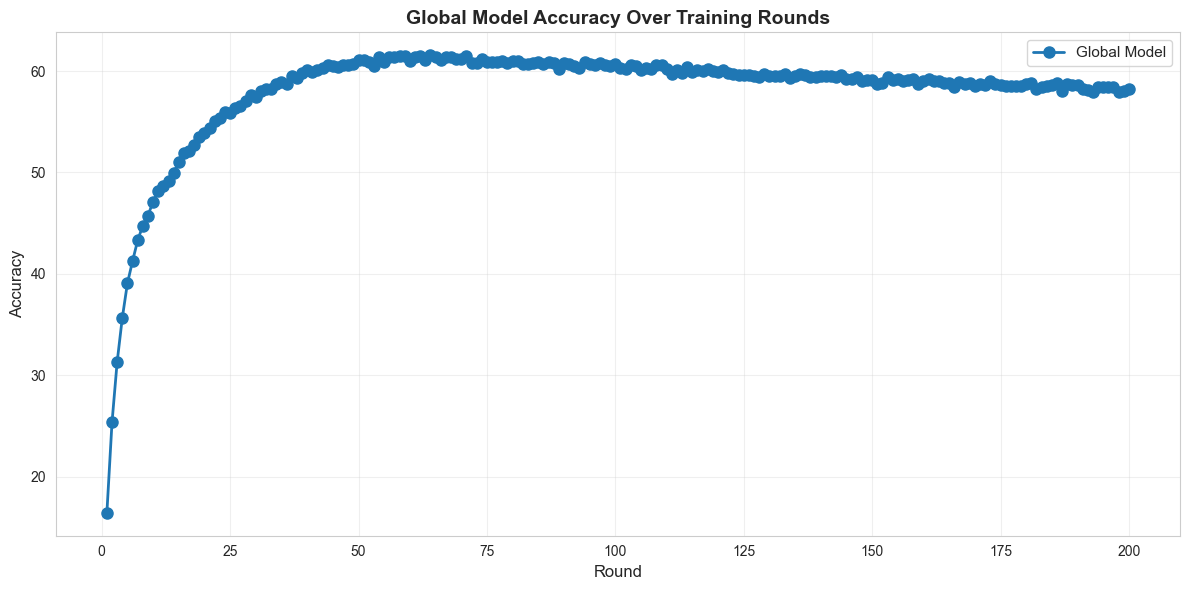

Final global accuracy: 58.2400
Best global accuracy: 61.5600 (round 64)
Average global accuracy: 58.0326


In [3]:
plt.figure(figsize=(12, 6))
plt.plot(global_metrics['round'], global_metrics['test_accuracy'], 
         marker='o', linewidth=2, markersize=8, label='Global Model')
plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Global Model Accuracy Over Training Rounds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Final global accuracy: {global_metrics['test_accuracy'].iloc[-1]:.4f}")
print(f"Best global accuracy: {global_metrics['test_accuracy'].max():.4f} (round {global_metrics.loc[global_metrics['test_accuracy'].idxmax(), 'round']})")
print(f"Average global accuracy: {global_metrics['test_accuracy'].mean():.4f}")

## 2b. Train vs Test Accuracy & Loss

Compare training metrics against test metrics to visualize the generalization gap.

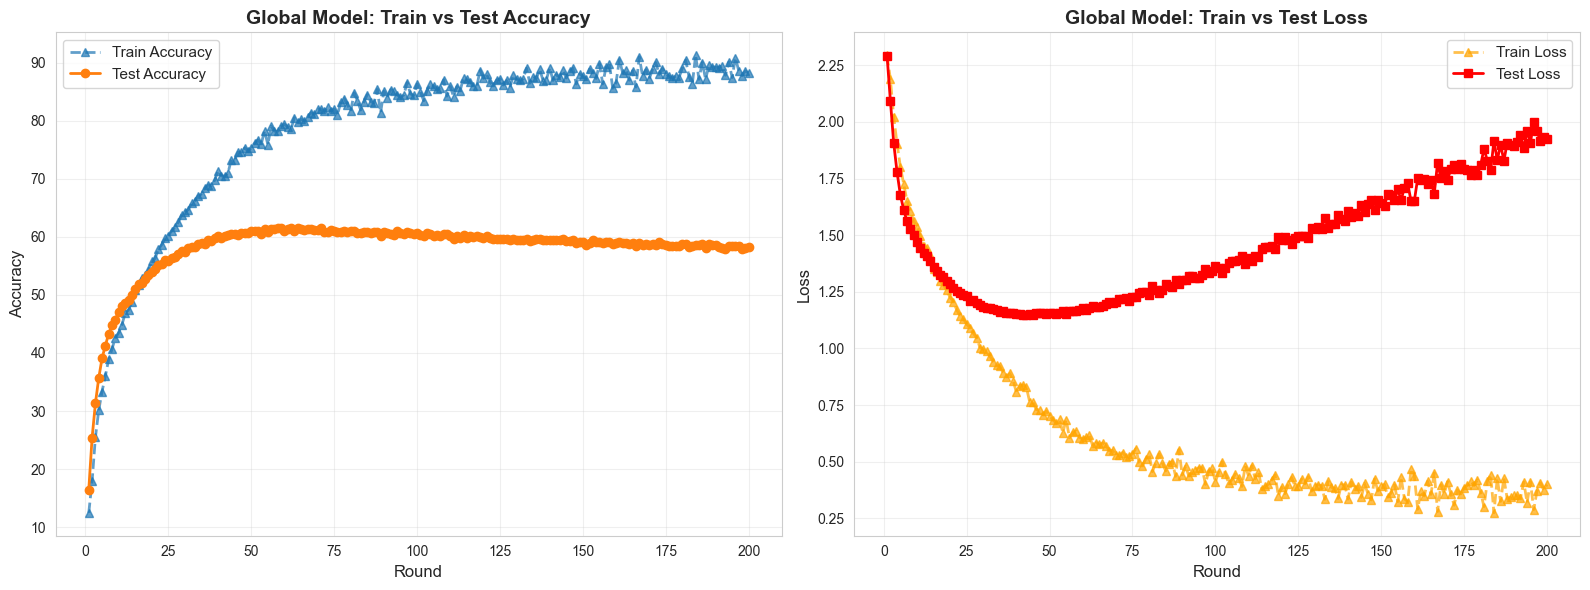

Final Round Generalization Gap:
  Train Accuracy: 88.2080
  Test Accuracy:  58.2400
  Gap: 29.9680

  Train Loss: 0.3993
  Test Loss:  1.9251
  Gap: 1.5258


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Train vs Test Accuracy (Global)
if 'train_accuracy' in global_metrics.columns:
    axes[0].plot(global_metrics['round'], global_metrics['train_accuracy'],
                 marker='^', linewidth=2, markersize=6, label='Train Accuracy', linestyle='--', alpha=0.7)
axes[0].plot(global_metrics['round'], global_metrics['test_accuracy'],
             marker='o', linewidth=2, markersize=6, label='Test Accuracy')
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Global Model: Train vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right: Train vs Test Loss (Global)
if 'train_loss' in global_metrics.columns:
    axes[1].plot(global_metrics['round'], global_metrics['train_loss'],
                 marker='^', linewidth=2, markersize=6, label='Train Loss', linestyle='--', alpha=0.7, color='orange')
axes[1].plot(global_metrics['round'], global_metrics['test_loss'],
             marker='s', linewidth=2, markersize=6, label='Test Loss', color='red')
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Global Model: Train vs Test Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print generalization gap
if 'train_accuracy' in global_metrics.columns:
    final = global_metrics.iloc[-1]
    print(f"Final Round Generalization Gap:")
    print(f"  Train Accuracy: {final['train_accuracy']:.4f}")
    print(f"  Test Accuracy:  {final['test_accuracy']:.4f}")
    print(f"  Gap: {final['train_accuracy'] - final['test_accuracy']:.4f}")
    print(f"\n  Train Loss: {final['train_loss']:.4f}")
    print(f"  Test Loss:  {final['test_loss']:.4f}")
    print(f"  Gap: {final['test_loss'] - final['train_loss']:.4f}")
else:
    print("Note: train_accuracy/train_loss columns not found. Re-run experiments with updated code.")

## 3. Global Model Loss

Track the global model's loss over rounds.

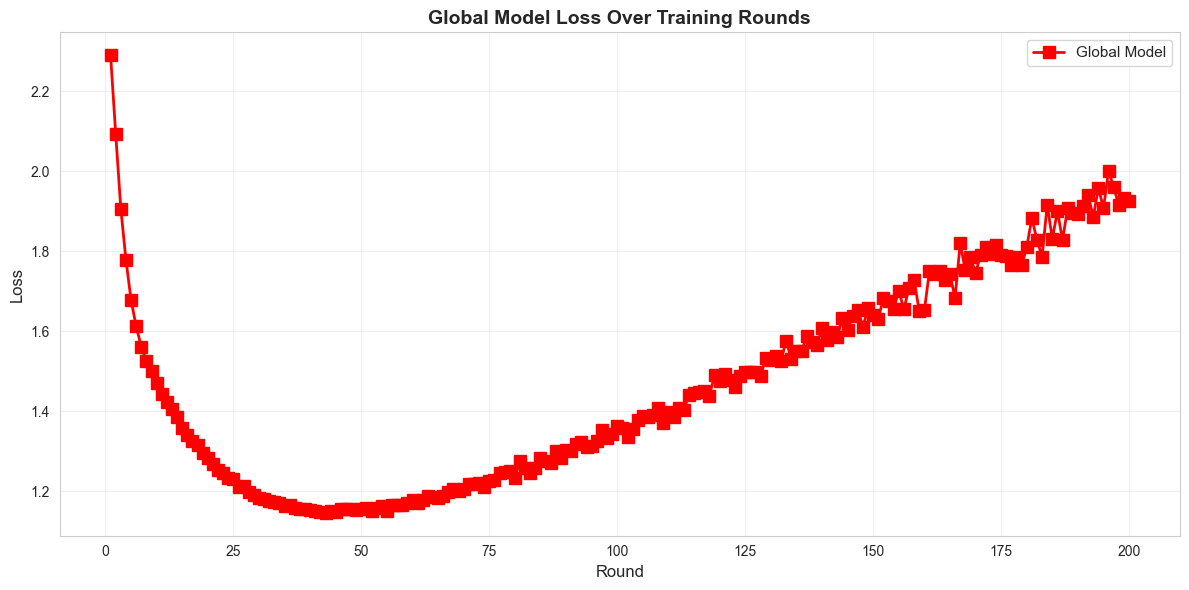

Final global loss: 1.9251
Best (lowest) global loss: 1.1460 (round 43)
Average global loss: 1.4667


In [5]:
plt.figure(figsize=(12, 6))
plt.plot(global_metrics['round'], global_metrics['test_loss'], 
         marker='s', linewidth=2, markersize=8, label='Global Model', color='red')
plt.xlabel('Round', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Global Model Loss Over Training Rounds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Final global loss: {global_metrics['test_loss'].iloc[-1]:.4f}")
print(f"Best (lowest) global loss: {global_metrics['test_loss'].min():.4f} (round {global_metrics.loc[global_metrics['test_loss'].idxmin(), 'round']})")
print(f"Average global loss: {global_metrics['test_loss'].mean():.4f}")

## 4. Global Model Gradient Metrics

Track gradient norm and gradient change for the global model.

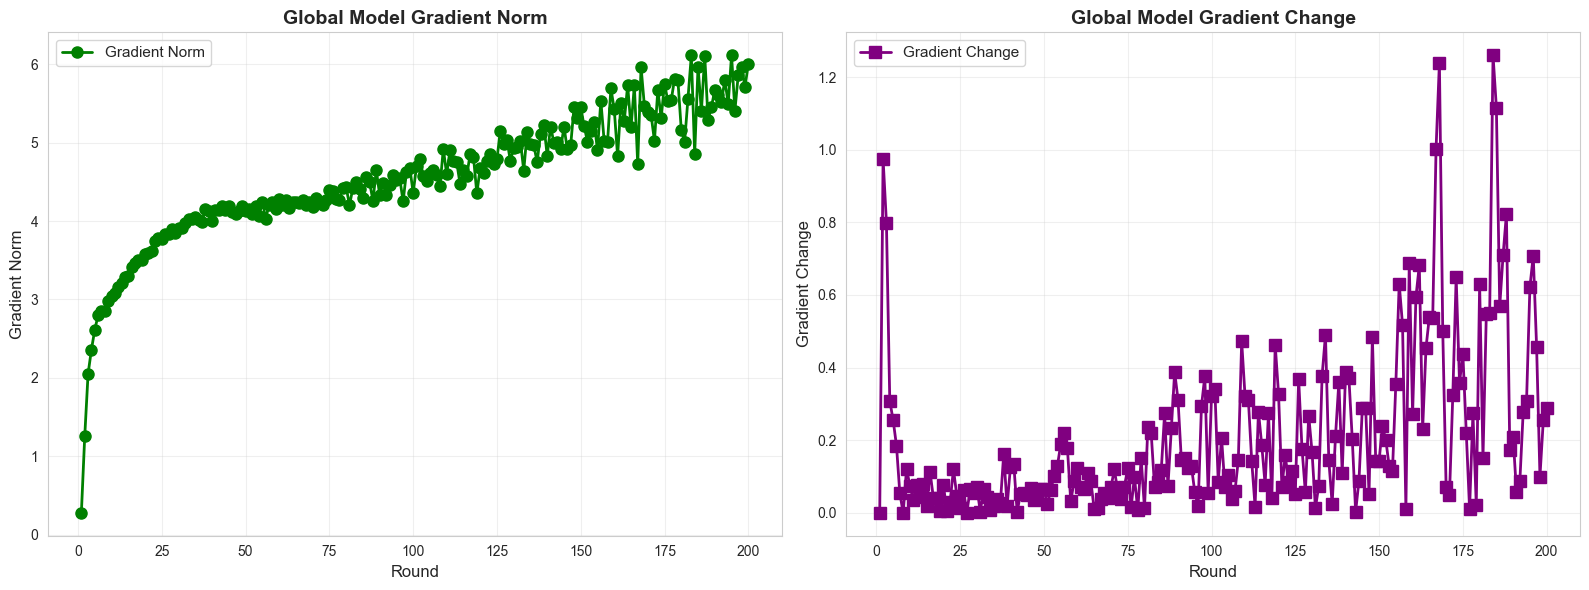

Final gradient norm: 5.9987
Average gradient norm: 4.5447
Final gradient change: 0.2890
Average gradient change: 0.2096


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gradient Norm
axes[0].plot(global_metrics['round'], global_metrics['gradient_norm'], 
             marker='o', linewidth=2, markersize=8, label='Gradient Norm', color='green')
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Gradient Norm', fontsize=12)
axes[0].set_title('Global Model Gradient Norm', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Gradient Change (skip first round since it has no previous to compare to)
gradient_change_data = global_metrics[global_metrics['round'] > 0]
axes[1].plot(gradient_change_data['round'], gradient_change_data['gradient_change'], 
             marker='s', linewidth=2, markersize=8, label='Gradient Change', color='purple')
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Gradient Change', fontsize=12)
axes[1].set_title('Global Model Gradient Change', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Final gradient norm: {global_metrics['gradient_norm'].iloc[-1]:.4f}")
print(f"Average gradient norm: {global_metrics['gradient_norm'].mean():.4f}")
if len(gradient_change_data) > 0:
    print(f"Final gradient change: {gradient_change_data['gradient_change'].iloc[-1]:.4f}")
    print(f"Average gradient change: {gradient_change_data['gradient_change'].mean():.4f}")

## 5. Per-Client Accuracy Comparison

Compare accuracy across all clients over rounds.

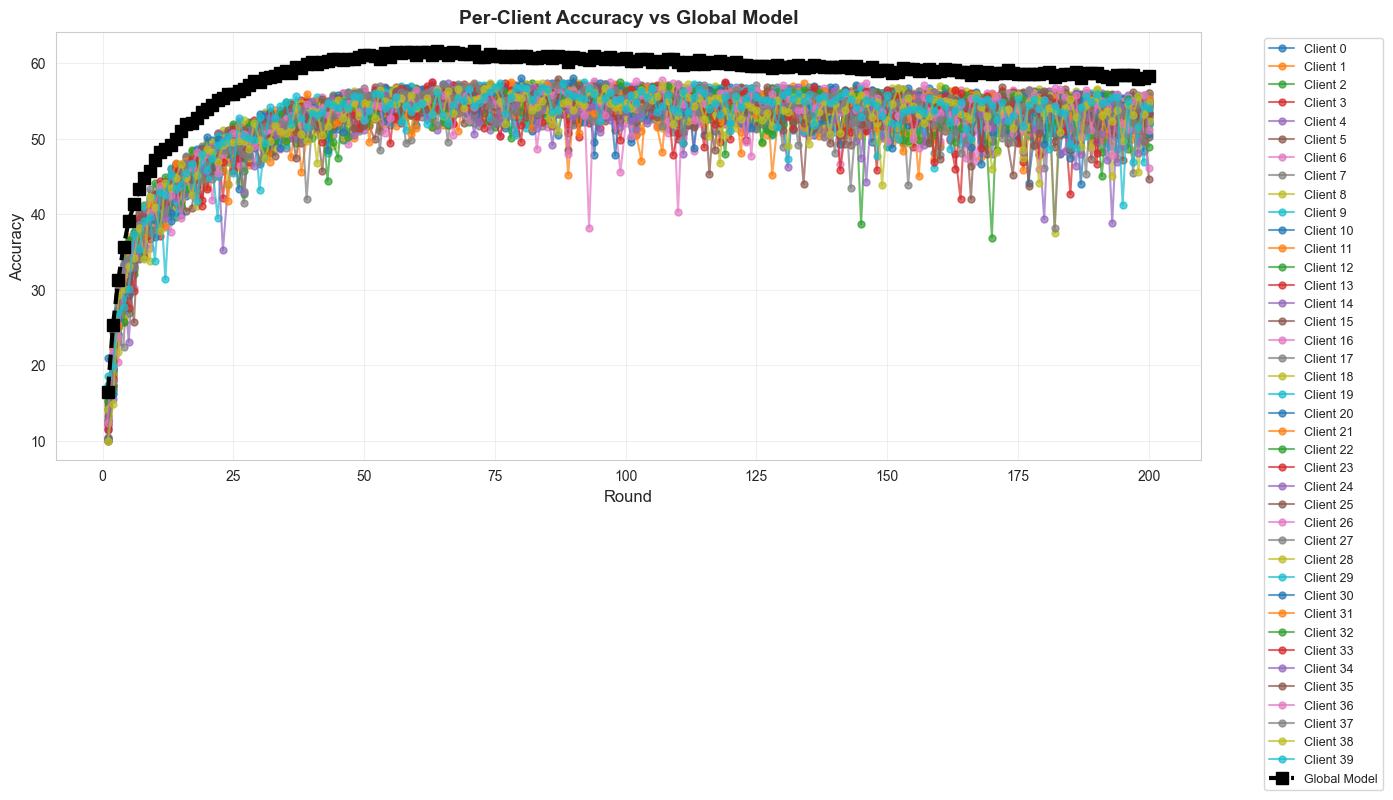


Final accuracies per client:
  Client 0.0: 55.2100
  Client 1.0: 53.8400
  Client 2.0: 55.0500
  Client 3.0: 54.7600
  Client 4.0: 55.9700
  Client 5.0: 44.6300
  Client 6.0: 55.1900
  Client 7.0: 53.4300
  Client 8.0: 51.2600
  Client 9.0: 54.6400
  Client 10.0: 55.9900
  Client 11.0: 53.0500
  Client 12.0: 51.9100
  Client 13.0: 52.0700
  Client 14.0: 52.8100
  Client 15.0: 50.1500
  Client 16.0: 54.7500
  Client 17.0: 52.8500
  Client 18.0: 52.4100
  Client 19.0: 51.7900
  Client 20.0: 52.3300
  Client 21.0: 55.9500
  Client 22.0: 54.1100
  Client 23.0: 54.8300
  Client 24.0: 53.3200
  Client 25.0: 53.2700
  Client 26.0: 46.0500
  Client 27.0: 55.5900
  Client 28.0: 52.3500
  Client 29.0: 53.9800
  Client 30.0: 50.6300
  Client 31.0: 55.2600
  Client 32.0: 48.9200
  Client 33.0: 54.4200
  Client 34.0: 54.8300
  Client 35.0: 53.4400
  Client 36.0: 51.1100
  Client 37.0: 54.3500
  Client 38.0: 54.7800
  Client 39.0: 53.9900

Global Model: 58.2400

Average client accuracy: 53.1317
Std

In [7]:
plt.figure(figsize=(14, 7))

# Plot each client's accuracy
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[client_metrics['client_id'] == client_id]
    plt.plot(client_data['round'], client_data['test_accuracy'], 
             marker='o', linewidth=1.5, markersize=5, label=f'Client {client_id}', alpha=0.7)

# Also plot global model for comparison
plt.plot(global_metrics['round'], global_metrics['test_accuracy'], 
         marker='s', linewidth=3, markersize=8, label='Global Model', color='black', linestyle='--')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Client Accuracy vs Global Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

# Print final accuracies
print("\nFinal accuracies per client:")
final_round = client_metrics['round'].max()
final_client_accuracies = client_metrics[client_metrics['round'] == final_round].sort_values('client_id')
for _, row in final_client_accuracies.iterrows():
    print(f"  Client {row['client_id']}: {row['test_accuracy']:.4f}")
print(f"\nGlobal Model: {global_metrics['test_accuracy'].iloc[-1]:.4f}")
print(f"\nAverage client accuracy: {final_client_accuracies['test_accuracy'].mean():.4f}")
print(f"Std dev: {final_client_accuracies['test_accuracy'].std():.4f}")

## 6. Per-Client Loss Comparison

Compare loss across all clients over rounds.

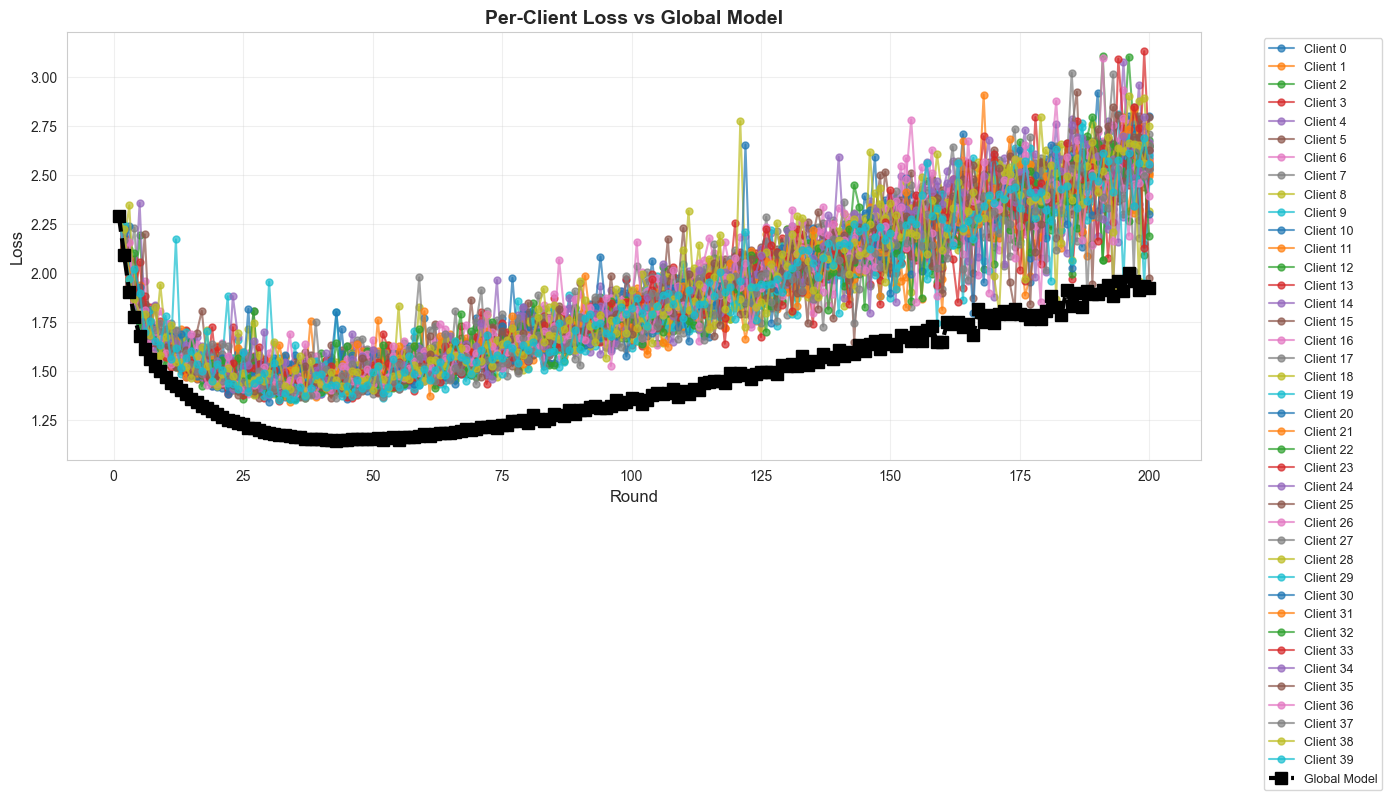


Final losses per client:
  Client 0.0: 2.8017
  Client 1.0: 2.5066
  Client 2.0: 2.6790
  Client 3.0: 2.6587
  Client 4.0: 2.6700
  Client 5.0: 1.9745
  Client 6.0: 2.5949
  Client 7.0: 2.7097
  Client 8.0: 2.3164
  Client 9.0: 2.6477
  Client 10.0: 2.6097
  Client 11.0: 2.4949
  Client 12.0: 2.6515
  Client 13.0: 2.5851
  Client 14.0: 2.6276
  Client 15.0: 2.6431
  Client 16.0: 2.5741
  Client 17.0: 2.6546
  Client 18.0: 2.5309
  Client 19.0: 2.4691
  Client 20.0: 2.5256
  Client 21.0: 2.5094
  Client 22.0: 2.5453
  Client 23.0: 2.5522
  Client 24.0: 2.6249
  Client 25.0: 2.7991
  Client 26.0: 2.2707
  Client 27.0: 2.6275
  Client 28.0: 2.5604
  Client 29.0: 2.5967
  Client 30.0: 2.3019
  Client 31.0: 2.5684
  Client 32.0: 2.1904
  Client 33.0: 2.5378
  Client 34.0: 2.5574
  Client 35.0: 2.6268
  Client 36.0: 2.3943
  Client 37.0: 2.5299
  Client 38.0: 2.7520
  Client 39.0: 2.5559

Global Model: 1.9251

Average client loss: 2.5507
Std dev: 0.1602


In [8]:
plt.figure(figsize=(14, 7))

# Plot each client's loss
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[client_metrics['client_id'] == client_id]
    plt.plot(client_data['round'], client_data['test_loss'], 
             marker='o', linewidth=1.5, markersize=5, label=f'Client {client_id}', alpha=0.7)

# Also plot global model for comparison
plt.plot(global_metrics['round'], global_metrics['test_loss'], 
         marker='s', linewidth=3, markersize=8, label='Global Model', color='black', linestyle='--')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Per-Client Loss vs Global Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

# Print final losses
print("\nFinal losses per client:")
final_round = client_metrics['round'].max()
final_client_losses = client_metrics[client_metrics['round'] == final_round].sort_values('client_id')
for _, row in final_client_losses.iterrows():
    print(f"  Client {row['client_id']}: {row['test_loss']:.4f}")
print(f"\nGlobal Model: {global_metrics['test_loss'].iloc[-1]:.4f}")
print(f"\nAverage client loss: {final_client_losses['test_loss'].mean():.4f}")
print(f"Std dev: {final_client_losses['test_loss'].std():.4f}")

## 7. Per-Client Gradient Metrics

Analyze gradient norms and changes across clients.

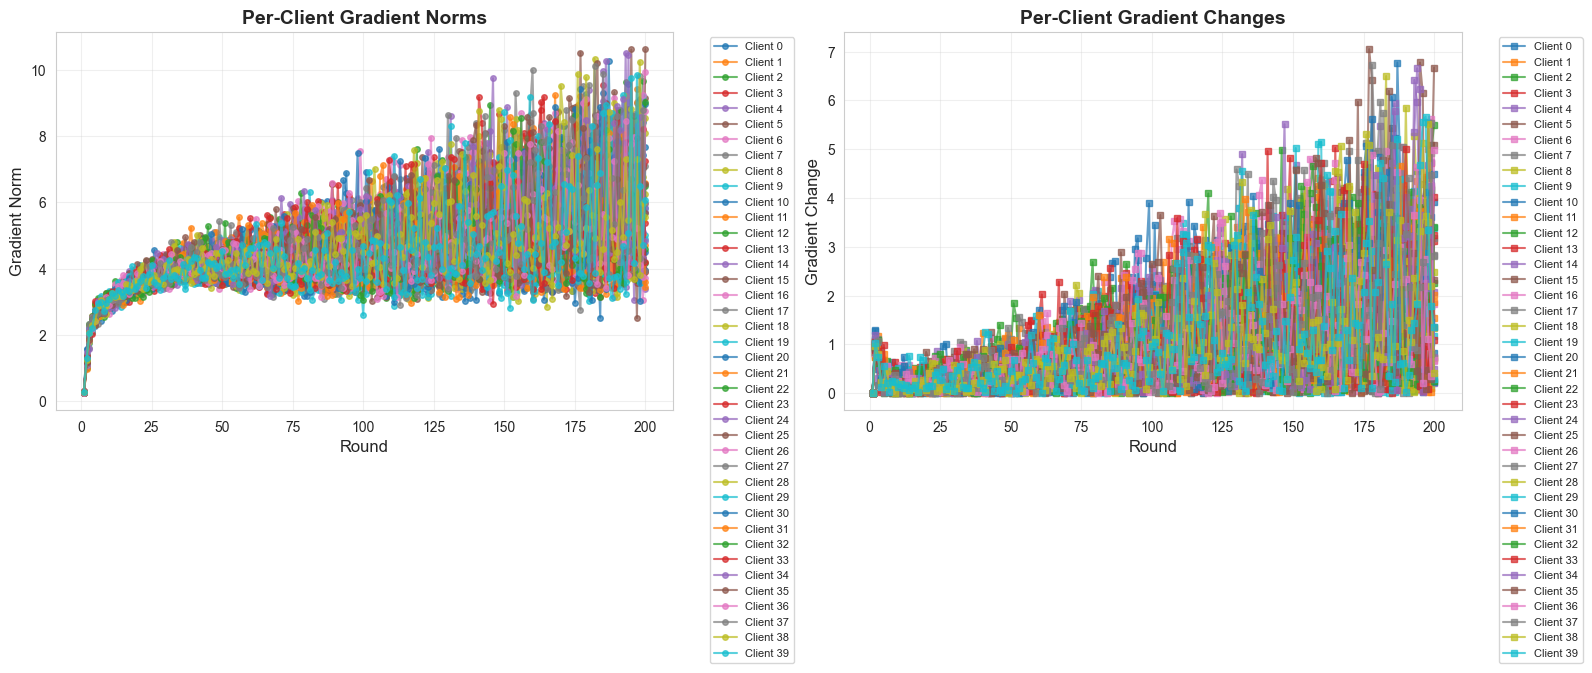


Final gradient norms per client:
  Client 0.0: 4.4950
  Client 1.0: 4.7296
  Client 2.0: 4.1643
  Client 3.0: 5.3766
  Client 4.0: 3.3861
  Client 5.0: 10.6248
  Client 6.0: 3.7263
  Client 7.0: 3.9410
  Client 8.0: 8.1055
  Client 9.0: 5.0063
  Client 10.0: 3.9777
  Client 11.0: 6.5876
  Client 12.0: 6.5022
  Client 13.0: 7.2593
  Client 14.0: 5.7179
  Client 15.0: 9.1498
  Client 16.0: 5.9518
  Client 17.0: 7.1130
  Client 18.0: 6.2706
  Client 19.0: 5.8322
  Client 20.0: 7.6756
  Client 21.0: 3.4543
  Client 22.0: 4.5909
  Client 23.0: 3.8936
  Client 24.0: 5.8388
  Client 25.0: 5.6905
  Client 26.0: 9.9212
  Client 27.0: 3.9395
  Client 28.0: 8.5377
  Client 29.0: 4.9118
  Client 30.0: 8.9614
  Client 31.0: 3.6103
  Client 32.0: 9.0255
  Client 33.0: 4.2007
  Client 34.0: 4.8328
  Client 35.0: 6.5636
  Client 36.0: 8.7555
  Client 37.0: 5.9716
  Client 38.0: 5.5677
  Client 39.0: 6.0861

Average gradient norm: 5.9987
Std dev: 1.9462


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gradient Norm
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[client_metrics['client_id'] == client_id]
    axes[0].plot(client_data['round'], client_data['gradient_norm'], 
                 marker='o', linewidth=1.5, markersize=4, label=f'Client {client_id}', alpha=0.7)

axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Gradient Norm', fontsize=12)
axes[0].set_title('Per-Client Gradient Norms', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Gradient Change (skip first round)
for client_id in sorted(client_metrics['client_id'].unique()):
    client_data = client_metrics[(client_metrics['client_id'] == client_id) & (client_metrics['round'] > 0)]
    axes[1].plot(client_data['round'], client_data['gradient_change'], 
                 marker='s', linewidth=1.5, markersize=4, label=f'Client {client_id}', alpha=0.7)

axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Gradient Change', fontsize=12)
axes[1].set_title('Per-Client Gradient Changes', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# Print statistics
final_round = client_metrics['round'].max()
final_gradient_norms = client_metrics[client_metrics['round'] == final_round]
print(f"\nFinal gradient norms per client:")
for _, row in final_gradient_norms.sort_values('client_id').iterrows():
    print(f"  Client {row['client_id']}: {row['gradient_norm']:.4f}")
print(f"\nAverage gradient norm: {final_gradient_norms['gradient_norm'].mean():.4f}")
print(f"Std dev: {final_gradient_norms['gradient_norm'].std():.4f}")

## 8. Global Per-Class Accuracy

Show how the global model performs on each class.

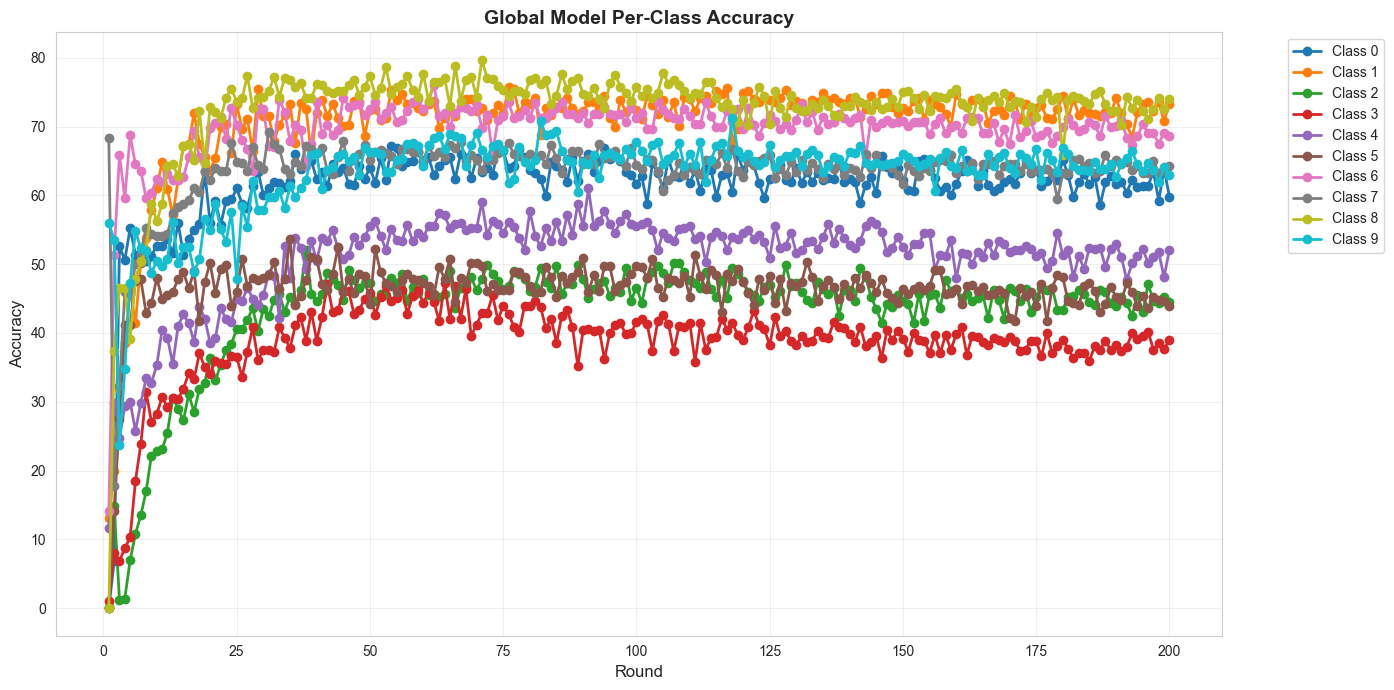


Final global model per-class accuracies:
  Class 0.0: 59.8000 (loss: 0.0000)
  Class 1.0: 73.3000 (loss: 0.0000)
  Class 2.0: 44.5000 (loss: 0.0000)
  Class 3.0: 39.0000 (loss: 0.0000)
  Class 4.0: 52.1000 (loss: 0.0000)
  Class 5.0: 43.9000 (loss: 0.0000)
  Class 6.0: 68.6000 (loss: 0.0000)
  Class 7.0: 64.2000 (loss: 0.0000)
  Class 8.0: 74.0000 (loss: 0.0000)
  Class 9.0: 63.0000 (loss: 0.0000)

Average per-class accuracy: 58.2400
Std dev: 12.6729


In [10]:
plt.figure(figsize=(14, 7))

# Plot each class's accuracy
for class_id in sorted(global_per_class['class_id'].unique()):
    class_data = global_per_class[global_per_class['class_id'] == class_id]
    plt.plot(class_data['round'], class_data['class_accuracy'], 
             marker='o', linewidth=2, markersize=6, label=f'Class {class_id}')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Global Model Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Print final per-class accuracies
print("\nFinal global model per-class accuracies:")
final_round = global_per_class['round'].max()
final_class_accuracies = global_per_class[global_per_class['round'] == final_round].sort_values('class_id')
for _, row in final_class_accuracies.iterrows():
    print(f"  Class {row['class_id']}: {row['class_accuracy']:.4f} (loss: {row['class_loss']:.4f})")
print(f"\nAverage per-class accuracy: {final_class_accuracies['class_accuracy'].mean():.4f}")
print(f"Std dev: {final_class_accuracies['class_accuracy'].std():.4f}")

## 9. Client Per-Class Accuracy Comparison

Compare how different clients perform on each class (final round only for clarity).

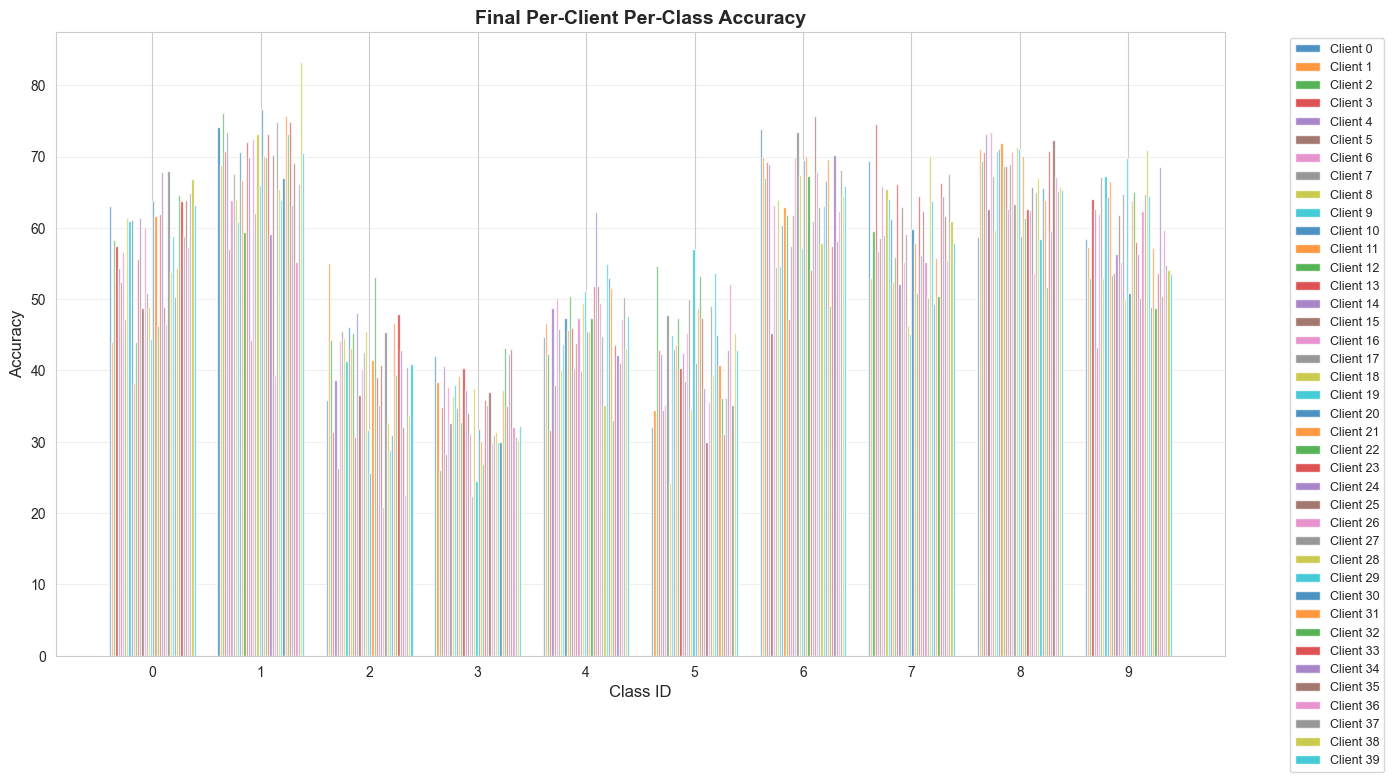


Per-class statistics across clients:
  Class 0: mean=56.3600, std=7.6571, min=38.3000, max=68.0000
  Class 1: mean=67.3550, std=8.3545, min=39.4000, max=83.3000
  Class 2: mean=38.9225, std=7.9770, min=20.8000, max=55.0000
  Class 3: mean=34.0875, std=5.0940, min=22.4000, max=43.1000
  Class 4: mean=45.8525, std=5.8946, min=31.7000, max=62.2000
  Class 5: mean=41.9425, std=7.4055, min=24.2000, max=57.0000
  Class 6: mean=63.2775, std=7.1723, min=45.3000, max=75.7000
  Class 7: mean=59.0800, std=6.7212, min=45.1000, max=74.6000
  Class 8: mean=65.9425, std=5.3443, min=51.7000, max=73.5000
  Class 9: mean=58.4975, std=6.7992, min=43.3000, max=70.9000


In [11]:
# Get final round data
final_round = client_per_class['round'].max()
final_data = client_per_class[client_per_class['round'] == final_round]

# Create a pivot table for easier plotting
pivot_accuracy = final_data.pivot(index='class_id', columns='client_id', values='class_accuracy')

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(pivot_accuracy.index))
width = 0.8 / len(pivot_accuracy.columns)

for i, client_id in enumerate(sorted(pivot_accuracy.columns)):
    offset = width * i - (0.8 - width) / 2
    ax.bar(x + offset, pivot_accuracy[client_id], width, label=f'Client {client_id}', alpha=0.8)

ax.set_xlabel('Class ID', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Final Per-Client Per-Class Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot_accuracy.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print statistics per class
print("\nPer-class statistics across clients:")
for class_id in sorted(pivot_accuracy.index):
    class_accuracies = pivot_accuracy.loc[class_id]
    print(f"  Class {class_id}: mean={class_accuracies.mean():.4f}, std={class_accuracies.std():.4f}, "
          f"min={class_accuracies.min():.4f}, max={class_accuracies.max():.4f}")

## 10. Global Per-Class F1 Score

F1 score balances precision and recall — more informative than accuracy alone, especially for imbalanced classes.

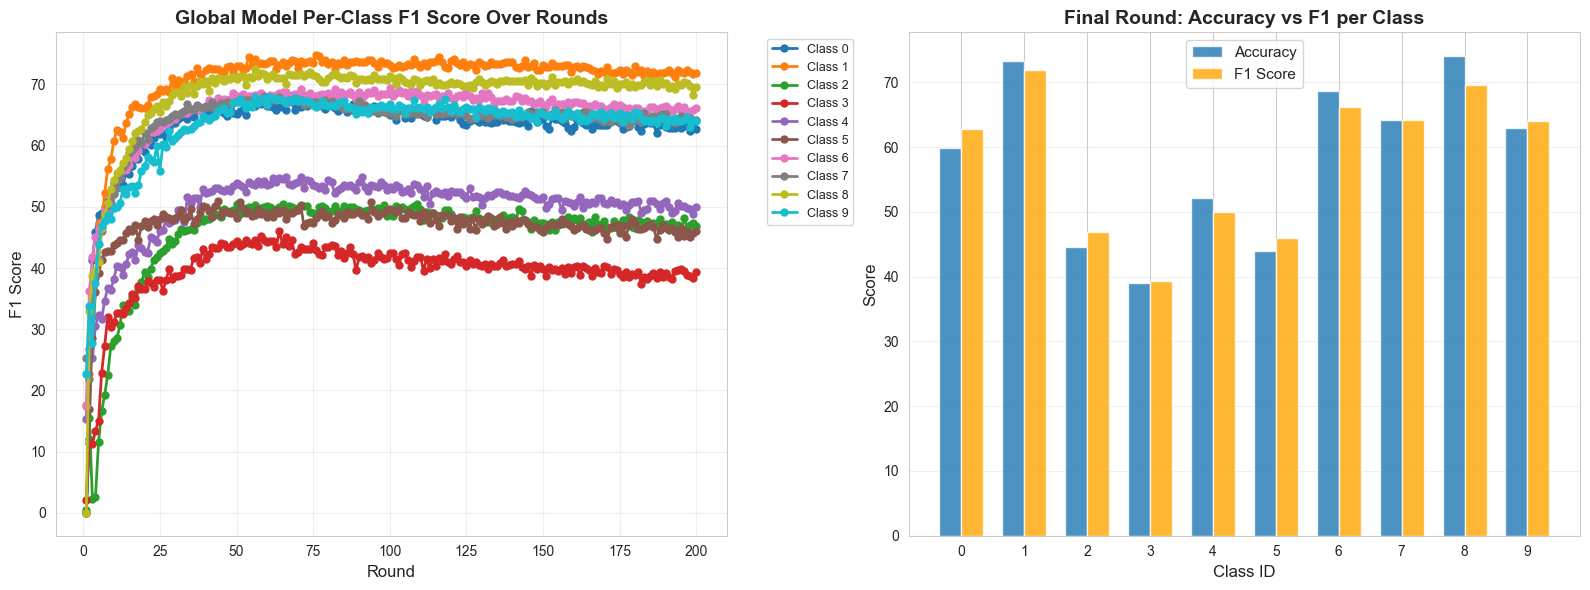


Final per-class F1 scores:
  Class 0: F1=62.7822  Acc=59.8000
  Class 1: F1=71.8980  Acc=73.3000
  Class 2: F1=46.8421  Acc=44.5000
  Class 3: F1=39.2749  Acc=39.0000
  Class 4: F1=49.9042  Acc=52.1000
  Class 5: F1=45.9686  Acc=43.9000
  Class 6: F1=66.1205  Acc=68.6000
  Class 7: F1=64.1038  Acc=64.2000
  Class 8: F1=69.6471  Acc=74.0000
  Class 9: F1=63.9919  Acc=63.0000

Mean F1: 58.0533 ± 11.4318


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: F1 per class over rounds
for class_id in sorted(global_per_class['class_id'].unique()):
    class_data = global_per_class[global_per_class['class_id'] == class_id].sort_values('round')
    ax1.plot(class_data['round'], class_data['class_f1_score'],
             marker='o', linewidth=2, markersize=5, label=f'Class {class_id}')

ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
ax1.set_title('Global Model Per-Class F1 Score Over Rounds', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: Final round bar chart (F1 vs Accuracy side by side)
final_round = global_per_class['round'].max()
final_class = global_per_class[global_per_class['round'] == final_round].sort_values('class_id')
x = np.arange(len(final_class))
w = 0.35
ax2.bar(x - w/2, final_class['class_accuracy'].values, w, label='Accuracy', alpha=0.8)
ax2.bar(x + w/2, final_class['class_f1_score'].values, w, label='F1 Score', alpha=0.8, color='orange')
ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Final Round: Accuracy vs F1 per Class', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(final_class['class_id'].values)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary
print("\nFinal per-class F1 scores:")
for _, row in final_class.iterrows():
    print(f"  Class {int(row['class_id'])}: F1={row['class_f1_score']:.4f}  Acc={row['class_accuracy']:.4f}")
print(f"\nMean F1: {final_class['class_f1_score'].mean():.4f} ± {final_class['class_f1_score'].std():.4f}")

## 11. Client Accuracy Spread Over Rounds

Box plot per round showing how FedAvg homogenizes clients — shrinking spread = successful aggregation.

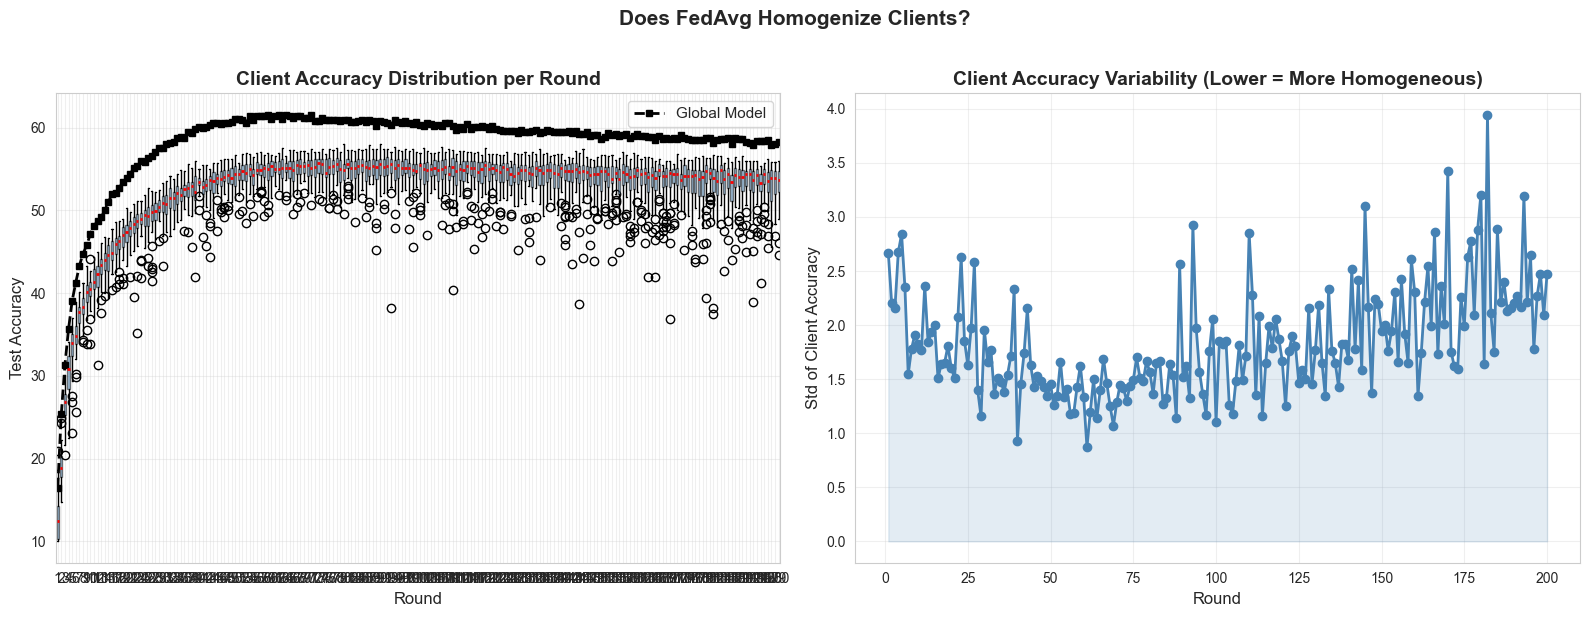

Accuracy Std  —  Round 1: 2.6635  →  Final: 2.4734  (Δ = -0.1901)


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

rounds = sorted(client_metrics['round'].unique())

# Left: Box plot of client test accuracy per round
acc_by_round = [client_metrics[client_metrics['round'] == r]['test_accuracy'].values for r in rounds]
bp1 = ax1.boxplot(acc_by_round, positions=rounds, widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor='steelblue', alpha=0.5),
                   medianprops=dict(color='red', linewidth=2))
ax1.plot(rounds, global_metrics.set_index('round').loc[rounds, 'test_accuracy'],
         color='black', linewidth=2, linestyle='--', marker='s', markersize=5, label='Global Model')
ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Client Accuracy Distribution per Round', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right: Std of client accuracy over rounds (convergence metric)
acc_std = client_metrics.groupby('round')['test_accuracy'].std().sort_index()
ax2.plot(acc_std.index, acc_std.values, color='steelblue', linewidth=2, marker='o', markersize=6)
ax2.fill_between(acc_std.index, 0, acc_std.values, alpha=0.15, color='steelblue')
ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Std of Client Accuracy', fontsize=12)
ax2.set_title('Client Accuracy Variability (Lower = More Homogeneous)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('Does FedAvg Homogenize Clients?', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Accuracy Std  —  Round 1: {acc_std.iloc[0]:.4f}  →  Final: {acc_std.iloc[-1]:.4f}  (Δ = {acc_std.iloc[-1] - acc_std.iloc[0]:+.4f})")

## 12. Per-Client Generalization Gap (Train - Test)

Shows whether individual clients overfit differently. Clients with larger local datasets or easier distributions may generalize better.

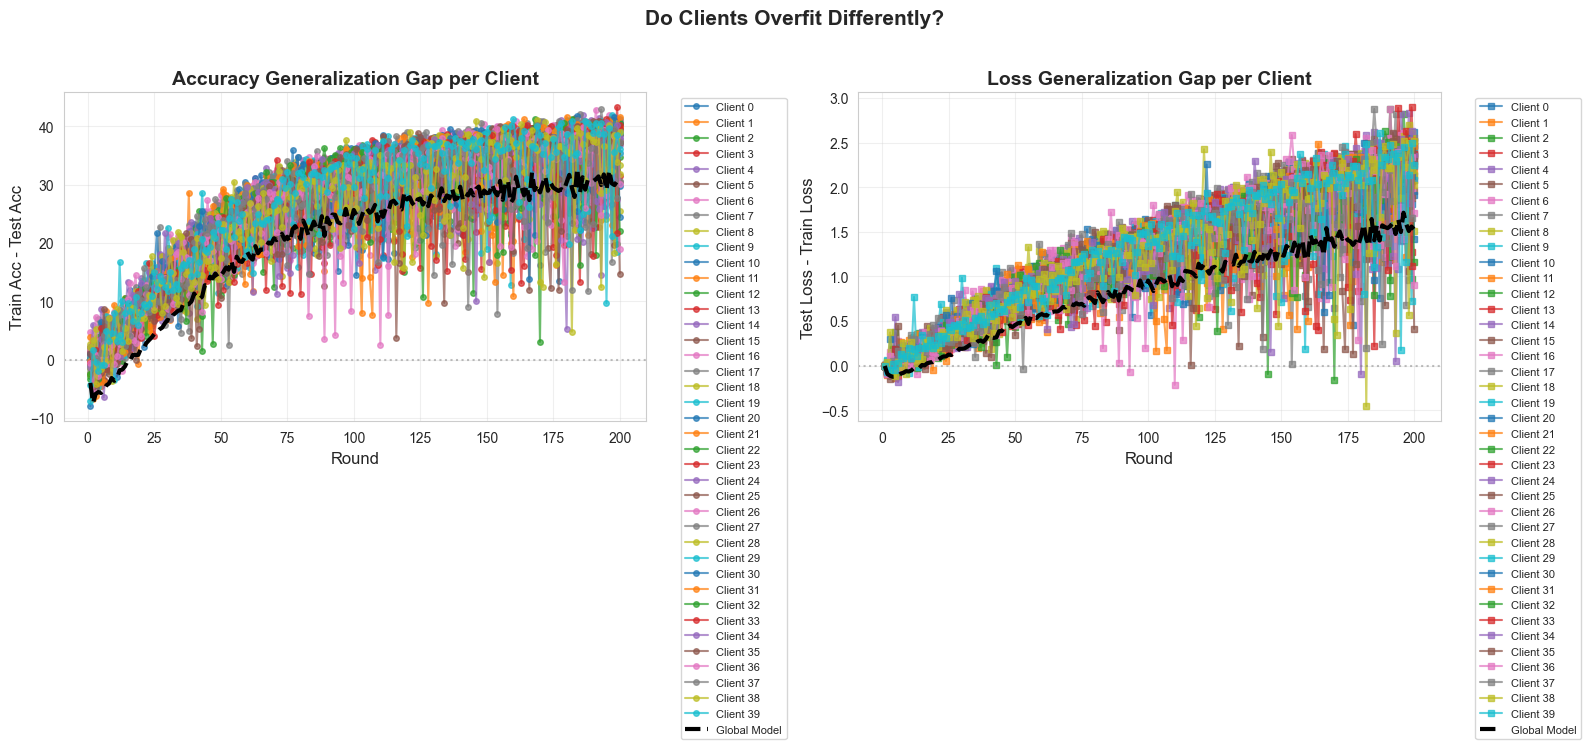


Final-round generalization gaps:
    Client    Acc Gap   Loss Gap
-----------------------------------
        C0  +38.5500    +2.6182
        C1  +38.8800    +2.3125
        C2  +39.7500    +2.5136
        C3  +38.6800    +2.4420
        C4  +40.1900    +2.5508
        C5  +14.7300    +0.4113
        C6  +40.9700    +2.4648
        C7  +41.2900    +2.5487
        C8  +25.5400    +1.5123
        C9  +39.0400    +2.4489
       C10  +40.4900    +2.4588
       C11  +37.4300    +2.1751
       C12  +34.7300    +2.2536
       C13  +31.5300    +2.0785
       C14  +37.7500    +2.3432
       C15  +30.4100    +1.9555
       C16  +35.4100    +2.2520
       C17  +30.6700    +2.1222
       C18  +33.2700    +2.1307
       C19  +35.4900    +2.0749
       C20  +29.7500    +1.9128
       C21  +39.8100    +2.3603
       C22  +40.5300    +2.3606
       C23  +39.4900    +2.3843
       C24  +36.7600    +2.3304
       C25  +37.2900    +2.5130
       C26  +18.9900    +0.9002
       C27  +39.2100    +2.4709
 

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

if 'train_accuracy' in client_metrics.columns:
    # Left: Accuracy gap per client
    for client_id in sorted(client_metrics['client_id'].unique()):
        cd = client_metrics[client_metrics['client_id'] == client_id].sort_values('round')
        gap = cd['train_accuracy'].values - cd['test_accuracy'].values
        ax1.plot(cd['round'], gap, marker='o', linewidth=1.5, markersize=4,
                 label=f'Client {client_id}', alpha=0.7)

    # Overlay global gap
    global_gap = global_metrics['train_accuracy'] - global_metrics['test_accuracy']
    ax1.plot(global_metrics['round'], global_gap, color='black', linewidth=3,
             linestyle='--', label='Global Model', zorder=10)

    ax1.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax1.set_xlabel('Round', fontsize=12)
    ax1.set_ylabel('Train Acc - Test Acc', fontsize=12)
    ax1.set_title('Accuracy Generalization Gap per Client', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Right: Loss gap per client (test - train; positive = overfitting)
    for client_id in sorted(client_metrics['client_id'].unique()):
        cd = client_metrics[client_metrics['client_id'] == client_id].sort_values('round')
        loss_gap = cd['test_loss'].values - cd['train_loss'].values
        ax2.plot(cd['round'], loss_gap, marker='s', linewidth=1.5, markersize=4,
                 label=f'Client {client_id}', alpha=0.7)

    global_loss_gap = global_metrics['test_loss'] - global_metrics['train_loss']
    ax2.plot(global_metrics['round'], global_loss_gap, color='black', linewidth=3,
             linestyle='--', label='Global Model', zorder=10)

    ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Round', fontsize=12)
    ax2.set_ylabel('Test Loss - Train Loss', fontsize=12)
    ax2.set_title('Loss Generalization Gap per Client', fontsize=14, fontweight='bold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'train_accuracy not available\nRe-run experiment with updated code',
             ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    ax2.text(0.5, 0.5, 'train_loss not available', ha='center', va='center',
             transform=ax2.transAxes, fontsize=14)

plt.suptitle('Do Clients Overfit Differently?', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print final round gaps
if 'train_accuracy' in client_metrics.columns:
    fr = client_metrics['round'].max()
    fc = client_metrics[client_metrics['round'] == fr].sort_values('client_id')
    print(f"\nFinal-round generalization gaps:")
    print(f"{'Client':>10s} {'Acc Gap':>10s} {'Loss Gap':>10s}")
    print("-" * 35)
    for _, row in fc.iterrows():
        ag = row['train_accuracy'] - row['test_accuracy']
        lg = row['test_loss'] - row['train_loss']
        print(f"{'C'+str(int(row['client_id'])):>10s} {ag:>+9.4f}  {lg:>+9.4f}")
    print(f"{'Global':>10s} {global_gap.iloc[-1]:>+9.4f}  {global_loss_gap.iloc[-1]:>+9.4f}")

## 13. Global vs Client Accuracy Gap

How much does each client deviate from the global model? A key FL fairness metric — ideally all clients converge to the global level.

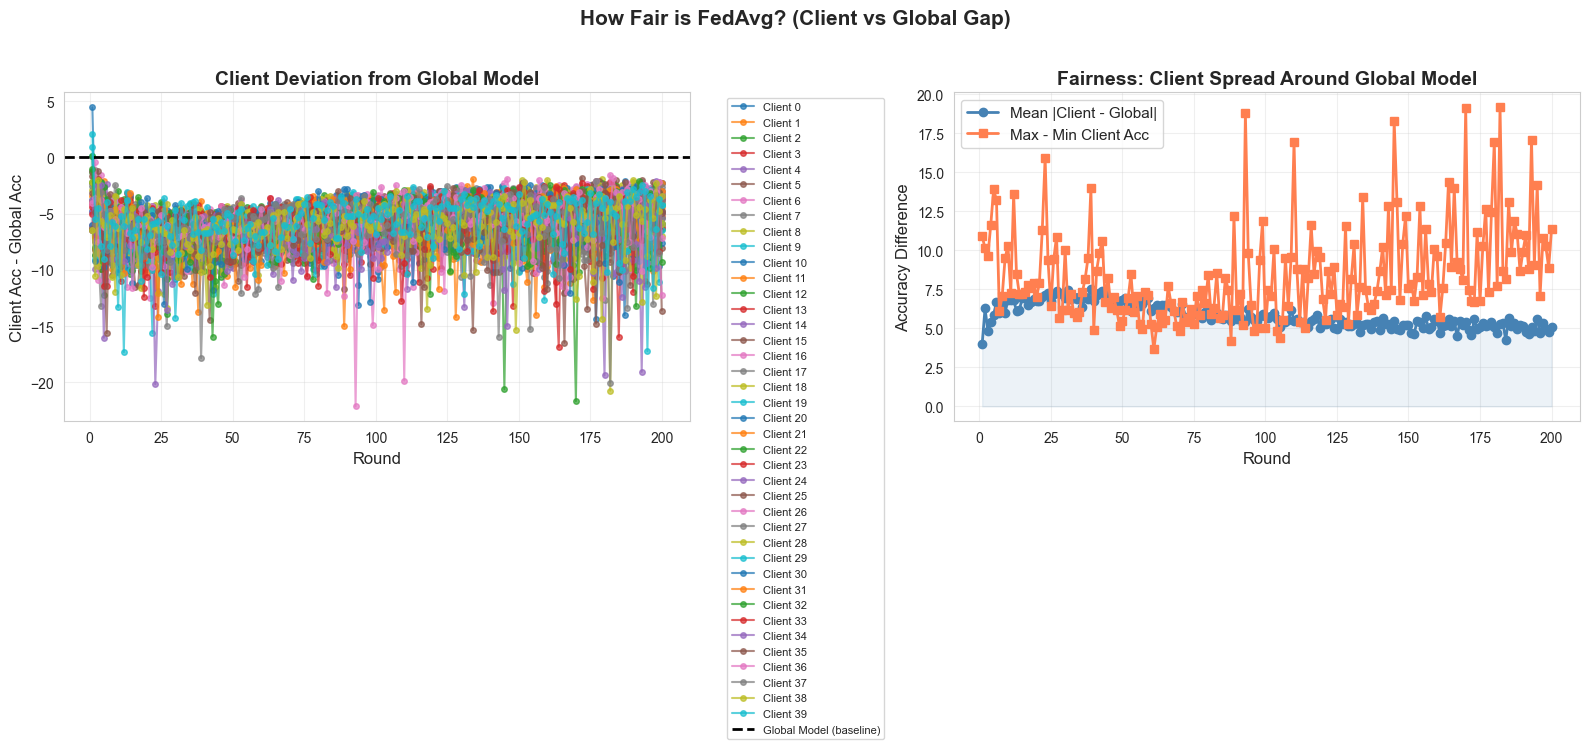


Final round — Global Accuracy: 58.2400
    Client   Accuracy   Δ Global
-----------------------------------
        C0   55.2100    -3.0300
        C1   53.8400    -4.4000
        C2   55.0500    -3.1900
        C3   54.7600    -3.4800
        C4   55.9700    -2.2700
        C5   44.6300   -13.6100
        C6   55.1900    -3.0500
        C7   53.4300    -4.8100
        C8   51.2600    -6.9800
        C9   54.6400    -3.6000
       C10   55.9900    -2.2500
       C11   53.0500    -5.1900
       C12   51.9100    -6.3300
       C13   52.0700    -6.1700
       C14   52.8100    -5.4300
       C15   50.1500    -8.0900
       C16   54.7500    -3.4900
       C17   52.8500    -5.3900
       C18   52.4100    -5.8300
       C19   51.7900    -6.4500
       C20   52.3300    -5.9100
       C21   55.9500    -2.2900
       C22   54.1100    -4.1300
       C23   54.8300    -3.4100
       C24   53.3200    -4.9200
       C25   53.2700    -4.9700
       C26   46.0500   -12.1900
       C27   55.5900    -2.

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

global_acc_by_round = global_metrics.set_index('round')['test_accuracy']

# Left: Per-client deviation from global (client_acc - global_acc)
for client_id in sorted(client_metrics['client_id'].unique()):
    cd = client_metrics[client_metrics['client_id'] == client_id].sort_values('round')
    deviation = cd['test_accuracy'].values - global_acc_by_round.loc[cd['round'].values].values
    ax1.plot(cd['round'], deviation, marker='o', linewidth=1.5, markersize=4,
             label=f'Client {client_id}', alpha=0.7)

ax1.axhline(y=0, color='black', linewidth=2, linestyle='--', label='Global Model (baseline)')
ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('Client Acc - Global Acc', fontsize=12)
ax1.set_title('Client Deviation from Global Model', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Right: Mean absolute deviation + max spread
rounds = sorted(client_metrics['round'].unique())
mad_vals = []
max_spread = []
for r in rounds:
    round_accs = client_metrics[client_metrics['round'] == r]['test_accuracy']
    global_val = global_acc_by_round.loc[r]
    mad_vals.append(np.abs(round_accs - global_val).mean())
    max_spread.append(round_accs.max() - round_accs.min())

ax2.plot(rounds, mad_vals, color='steelblue', linewidth=2, marker='o', markersize=6, label='Mean |Client - Global|')
ax2.plot(rounds, max_spread, color='coral', linewidth=2, marker='s', markersize=6, label='Max - Min Client Acc')
ax2.fill_between(rounds, 0, mad_vals, alpha=0.1, color='steelblue')
ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Accuracy Difference', fontsize=12)
ax2.set_title('Fairness: Client Spread Around Global Model', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.suptitle('How Fair is FedAvg? (Client vs Global Gap)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary
fr = client_metrics['round'].max()
fc = client_metrics[client_metrics['round'] == fr].sort_values('client_id')
global_final = global_acc_by_round.loc[fr]
print(f"\nFinal round — Global Accuracy: {global_final:.4f}")
print(f"{'Client':>10s} {'Accuracy':>10s} {'Δ Global':>10s}")
print("-" * 35)
for _, row in fc.iterrows():
    delta = row['test_accuracy'] - global_final
    print(f"{'C'+str(int(row['client_id'])):>10s} {row['test_accuracy']:>9.4f}  {delta:>+9.4f}")
print(f"\nMAD from global: {mad_vals[-1]:.4f}")
print(f"Max spread: {max_spread[-1]:.4f}")

## 14. Summary Statistics

Overall summary of the centralized training experiment.

In [16]:
print("="*60)
print("CENTRALIZED FEDERATED LEARNING - SUMMARY STATISTICS")
print("="*60)

print("\n📊 GLOBAL MODEL PERFORMANCE")
print("-" * 60)
print(f"Final Accuracy:        {global_metrics['test_accuracy'].iloc[-1]:.4f}")
print(f"Best Accuracy:         {global_metrics['test_accuracy'].max():.4f} (Round {global_metrics.loc[global_metrics['test_accuracy'].idxmax(), 'round']})")
print(f"Final Loss:            {global_metrics['test_loss'].iloc[-1]:.4f}")
print(f"Best Loss:             {global_metrics['test_loss'].min():.4f} (Round {global_metrics.loc[global_metrics['test_loss'].idxmin(), 'round']})")
print(f"Final Gradient Norm:   {global_metrics['gradient_norm'].iloc[-1]:.4f}")

print("\n👥 CLIENT PERFORMANCE")
print("-" * 60)
final_round = client_metrics['round'].max()
final_clients = client_metrics[client_metrics['round'] == final_round]
print(f"Number of Clients:     {len(final_clients)}")
print(f"Avg Client Accuracy:   {final_clients['test_accuracy'].mean():.4f} ± {final_clients['test_accuracy'].std():.4f}")
print(f"Best Client:           {final_clients.loc[final_clients['test_accuracy'].idxmax(), 'client_id']} "
      f"({final_clients['test_accuracy'].max():.4f})")
print(f"Worst Client:          {final_clients.loc[final_clients['test_accuracy'].idxmin(), 'client_id']} "
      f"({final_clients['test_accuracy'].min():.4f})")
print(f"Avg Client Loss:       {final_clients['test_loss'].mean():.4f} ± {final_clients['test_loss'].std():.4f}")

print("\n🎯 PER-CLASS PERFORMANCE (GLOBAL MODEL)")
print("-" * 60)
final_classes = global_per_class[global_per_class['round'] == final_round]
print(f"Number of Classes:     {len(final_classes)}")
print(f"Avg Class Accuracy:    {final_classes['class_accuracy'].mean():.4f} ± {final_classes['class_accuracy'].std():.4f}")
print(f"Best Class:            {final_classes.loc[final_classes['class_accuracy'].idxmax(), 'class_id']} "
      f"({final_classes['class_accuracy'].max():.4f})")
print(f"Worst Class:           {final_classes.loc[final_classes['class_accuracy'].idxmin(), 'class_id']} "
      f"({final_classes['class_accuracy'].min():.4f})")

print("\n📈 TRAINING DYNAMICS")
print("-" * 60)
print(f"Total Rounds:          {len(global_metrics)}")
accuracy_improvement = global_metrics['test_accuracy'].iloc[-1] - global_metrics['test_accuracy'].iloc[0]
loss_improvement = global_metrics['test_loss'].iloc[0] - global_metrics['test_loss'].iloc[-1]
print(f"Accuracy Improvement:  {accuracy_improvement:+.4f} ({accuracy_improvement/global_metrics['test_accuracy'].iloc[0]*100:+.2f}%)")
print(f"Loss Improvement:      {loss_improvement:+.4f} ({loss_improvement/global_metrics['test_loss'].iloc[0]*100:+.2f}%)")

# Calculate convergence indicator (gradient stabilization)
if len(global_metrics) > 5:
    recent_gradient_std = global_metrics['gradient_norm'].iloc[-5:].std()
    print(f"Recent Gradient Std:   {recent_gradient_std:.4f} (convergence indicator)")

print("\n" + "="*60)
print(f"Experiment: {experiment_dir.name}")
print(f"Location: {experiment_dir}")
print("="*60)

CENTRALIZED FEDERATED LEARNING - SUMMARY STATISTICS

📊 GLOBAL MODEL PERFORMANCE
------------------------------------------------------------
Final Accuracy:        58.2400
Best Accuracy:         61.5600 (Round 64)
Final Loss:            1.9251
Best Loss:             1.1460 (Round 43)
Final Gradient Norm:   5.9987

👥 CLIENT PERFORMANCE
------------------------------------------------------------
Number of Clients:     40
Avg Client Accuracy:   53.1317 ± 2.4734
Best Client:           10 (55.9900)
Worst Client:          5 (44.6300)
Avg Client Loss:       2.5507 ± 0.1602

🎯 PER-CLASS PERFORMANCE (GLOBAL MODEL)
------------------------------------------------------------
Number of Classes:     10
Avg Class Accuracy:    58.2400 ± 12.6729
Best Class:            8 (74.0000)
Worst Class:           3 (39.0000)

📈 TRAINING DYNAMICS
------------------------------------------------------------
Total Rounds:          200
Accuracy Improvement:  +41.7900 (+254.04%)
Loss Improvement:      +0.3648 (+15.